# Figure 9.
| Author  | Stanley A. Baronett  |
|---------|----------------------|
| Created |  08/23/2025          |
| Updated |  08/23/2025          |

Equilibrium temperatures $T_\mathrm{eq}$ from models sharing the same gray absorption opacity $\kappa^\mathrm{abs} = 300\mathrm{\,cm^2\,g^{-1}}$.
The left panels show radial profiles, while the right ones show them as functions of gray optical depth $\tau$ [cf. equation (19)].
The upper panels show absolute temperatures, while the lower ones show the relative difference between RADMC-3D (Section 4.1.1) and Athena++ with either our multigroup radiation transport framework (Section 2) or a hybrid ray-tracing method for stellar irradiation (Section 4.1.2).
Lines styles correspond to profiles at different disk latitudes (cf. Figure 6), while colors show different codes.

Opacity		Section	Latitude	Optical Depths		Rel. Diff. in \Teq(θ)
								Avg.	Max.
(cm^2\gm^{-1})		(deg)					(%)	(%)
(1)		(2)	(4)		(5)			(6/8)	(7/9)
\kabs = 300	4.2.2						Multigroup
			30		3e-11 < τ < 2e-08	1%	3%
			10		3e-07 < τ < 2e+00	1%	1%
			0		5e-03 < τ < 2e+02	5%	11%
\kabs = 300	4.2.2						Hybrid
			30		3e-11 < τ < 2e-08	0%	1%
			10		3e-07 < τ < 2e+00	1%	2%
			0		5e-03 < τ < 2e+02	6%	16%


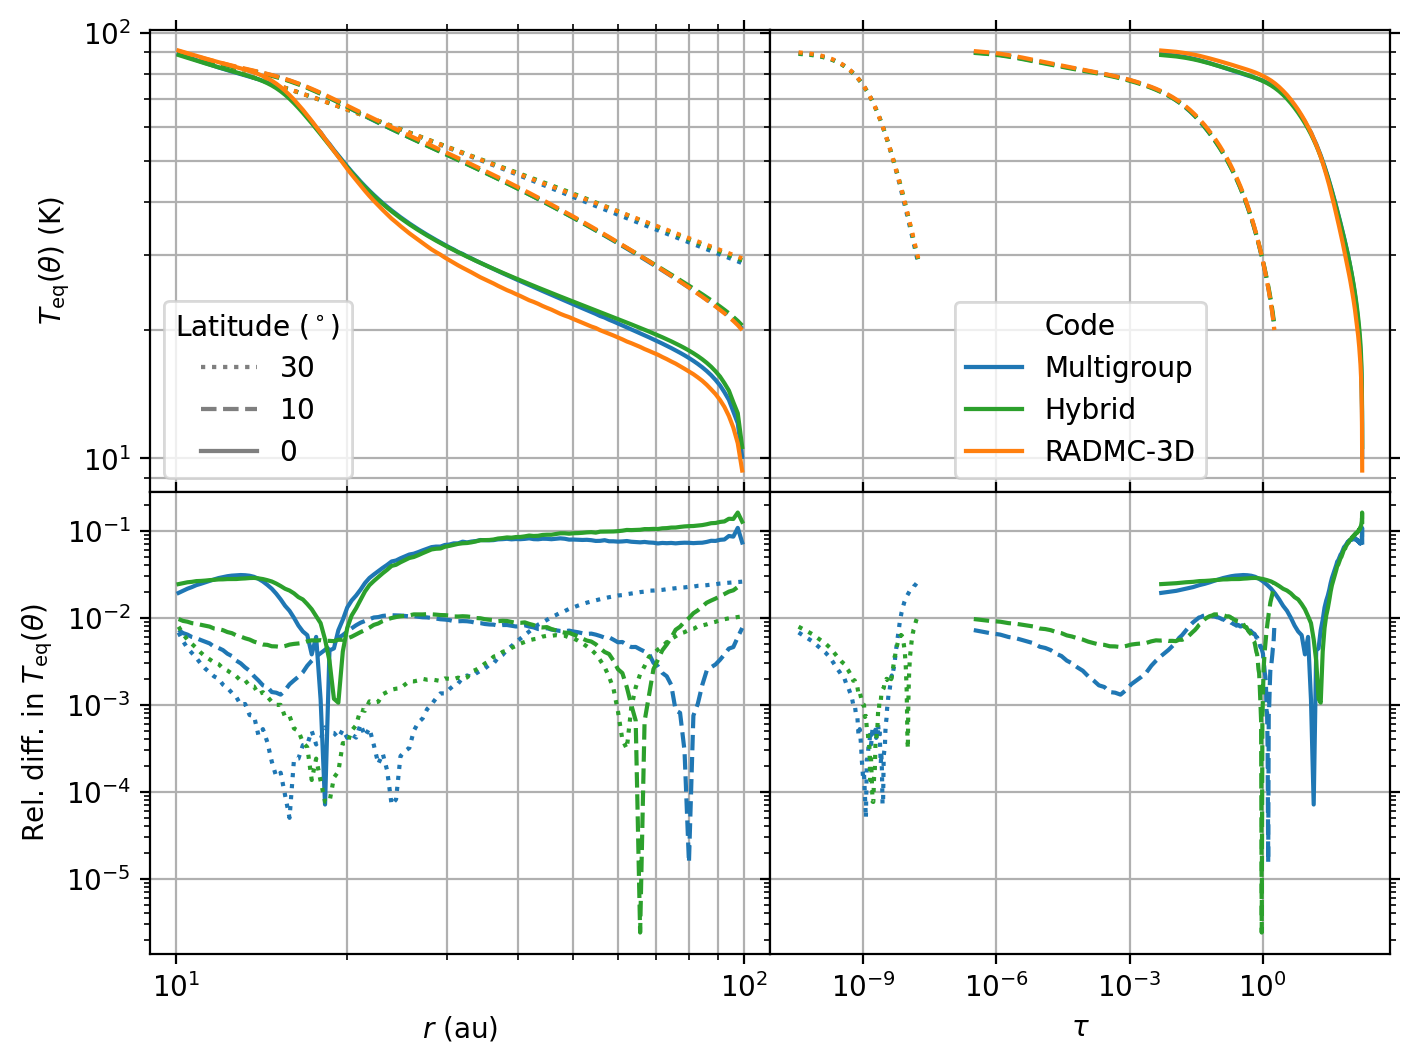

In [2]:
#===============================================================================
import athena_read
import matplotlib.pyplot as plt
import numpy as np

# Constants
au = 1.495978707e13           # astronomical unit [cm]
rad2deg = 180/np.pi

# Prepare plots
fig, axs = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row',
                        figsize=(8, 6), dpi=200)
lss = ['dotted', 'dashed', 'solid']
theta_degs = [60, 80, 90]
c_solns, ls_thetas = [], []

# RADMC-3D
root = '../radmc3d'
run = 'gray_opac'
path = f'{root}/{run}'
grid = np.load(f'{path}/amr_grid.npz', allow_pickle=True)['grid'][()]
taux = np.load(f'{path}/taux.npz')['taux']
dusttemp = np.load(f'{path}/dust_temperature.npz')['dusttemp']

# Athena++
root = '../athena/models/gray_opac/absorption'
runs = ['multigroup', 'hybrid']
code = ['Multigroup', 'Hybrid']
problem_id = ['dsharp', 'disk']
output = ['00001', '00100']
c = ['tab:blue', 'tab:green', 'tab:orange']
print('Opacity\t\tSection\tLatitude\tOptical Depths\t\tRel. Diff. in \Teq(θ)')
print(f'\t\t\t\t\t\t\t\tAvg.\tMax.')
print('(cm^2\gm^{-1})\t\t(deg)\t\t\t\t\t(%)\t(%)')
print('(1)\t\t(2)\t(4)\t\t(5)\t\t\t(6/8)\t(7/9)')
for i, run in enumerate(runs):
    path = f'{root}/{run}'
    if i == 0:
        athinput = athena_read.athinput(f'{path}/athinput.{problem_id[i]}')
        length_unit = athinput['radiation']['length_unit']
        t_unit = athinput['radiation']['T_unit']
    else:
        athinput = athena_read.athinput(f'{path}/athinput.{problem_id[i]}_sph_rad')
        length_unit = athinput['radiation']['lunit']
        t_unit = athinput['radiation']['Tunit']
    l_au = length_unit/au
    dtheta = (athinput['mesh']['x2max'] - athinput['mesh']['x2min'])\
            /athinput['mesh']['nx2']
    athdf = athena_read.athdf(f'{path}/athdf/{problem_id[i]}.out1.{output[i]}.athdf')
    dtau = athdf['Sigma_a_0'][0]*np.diff(athdf['x1f'])
    tau = np.cumsum(dtau, axis=1)
    temps = athdf['press'][0]/athdf['rho'][0]
    print(f'\kabs = 300\t4.2.2\t\t\t\t\t\t{code[i]}')
    for th, theta_deg in enumerate(theta_degs):
        j = int(theta_deg/rad2deg/dtheta)
        rel_diff_temp = 2*np.abs(temps[j, :]*t_unit - dusttemp[:,j,0,0])\
                     /(temps[j, :]*t_unit + dusttemp[:,j,0,0])
        axs[0][0].plot(athdf['x1v']*l_au, temps[j, :]*t_unit, color=c[i],
                       ls=lss[th])
        axs[0][1].plot(tau[j, :], temps[j, :]*t_unit, color=c[i],
                       ls=lss[th])
        axs[1][0].plot(athdf['x1v']*l_au, rel_diff_temp, color=c[i],
                       ls=lss[th])
        axs[1][1].plot(tau[j, :], rel_diff_temp, color=c[i], ls=lss[th])
        if i == 1:
            ls_thetas.append(axs[0][1].plot([], [], color='tab:gray',
                            ls=lss[th], label=rf'${90-theta_deg}$')[0])
            axs[0][0].plot(grid.x/au, dusttemp[:,j,0,0], color=c[i+1],
                            ls=lss[th])
            axs[0][1].plot(taux[:,j,0], dusttemp[:,j,0,0], color=c[i+1],
                            ls=lss[th])
        print(f'\t\t\t{90-theta_deg}\t\t{np.min(taux[:,j,0]):.0e} < τ < '\
              +f'{np.max(taux[:,j,0]):.0e}\t{np.mean(rel_diff_temp):.0%}\t'
              +f'{np.max(rel_diff_temp):.0%}')
    c_solns.append(axs[1][1].plot([], [], color=c[i],
                    label=f'{code[i]}')[0])
c_solns.append(axs[1][1].plot([], [], color=c[i+1],
               label='RADMC-3D')[0])

# Plot ghost points for colorless line style and add legends
axs[0][0].add_artist(axs[0][0].legend(framealpha=0.56, handles=ls_thetas,
                                      title=r'Latitude ($^\circ)$'))
axs[0][1].add_artist(axs[0][1].legend(framealpha=0.56, handles=c_solns,
                                      loc='lower center', title=r'Code'))

# Format plots
for ax in axs.flat:
    ax.grid()
    ax.minorticks_on()
    ax.set(xscale='log', yscale='log')
    ax.tick_params(axis='both', which='both', top=True, right=True)
axs[0][0].grid(axis='both', which='minor')
axs[0][1].grid(axis='y', which='minor')
axs[1][0].grid(axis='x', which='minor')
axs[0][0].set(ylabel=r'$T_\mathrm{eq}(\theta)$ (K)')
axs[1][0].set(xlabel=r'$r$ (au)',
              ylabel=r'Rel. diff. in $T_\mathrm{eq}(\theta)$')
axs[1][1].set(xlabel=r'$\tau$')
plt.subplots_adjust(hspace=0, wspace=0)
plt.savefig('figs/gray_absorption.pdf', bbox_inches='tight', pad_inches=0.01)
#===============================================================================